In [1]:
import sys
import os
#import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow.compat.v1 as tf
import tensorflow.keras.datasets.mnist as mnist
import random
#import cv2
import pandas as pd
tf.disable_v2_behavior()

%matplotlib inline
#%matplotlib widget
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")
%load_ext tensorboard

#from utils import gr_disp

def show_graph(g=None, gd=None):
    gr_disp.show_graph(g, gd)
    %tensorboard --logdir logs
    

Instructions for updating:
non-resource variables are not supported in the long term


# Preprocessing

## Data structure

The images have been extracted manually to create a training dataset. The source is the hispanic transcription manual. In this document several texts are available with the translations making it easier to extract the labels for specific written words. The manual is available here:

http://hispanicseminary.org/manual-en.htm

Images and labels are stored in a specific directory, each image is named with a unique number, that is used as the id to retrieve it's label from the spreadsheet that acts as database.

| Images folder       | Labels spreadsheet     |
| :------------- | :----------: |
| 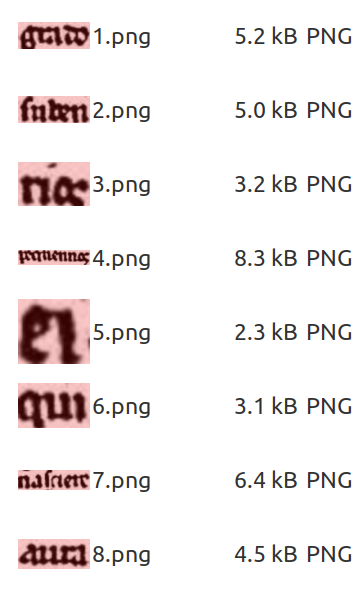  | 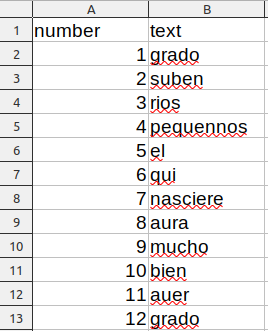 |

## Train set and data augmentation

Since only 375 images are available data augmentation has been used to increase the available data to train the model. The augmentation is based on stretching and contracting the images and applying slight rotations.

Charlist:
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'x', 'z', 'ç']

img --> train: (1659, 32, 150), test: (186, 32, 150), validation: (6, 32, 150)
text --> train: 1659, test: 186,validation: 6

Validation labels:
['auer', 'doro', 'adib', 'rios', 'anda', 'aura']


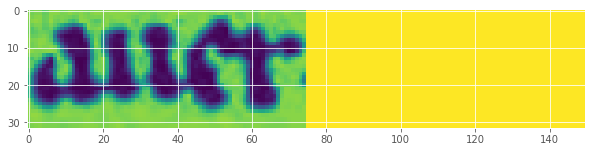

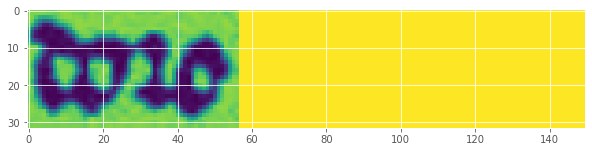

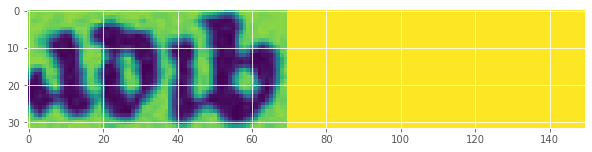

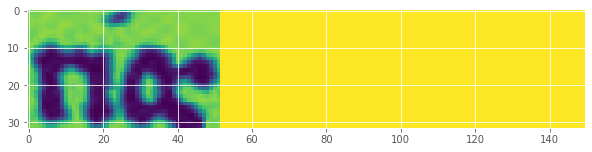

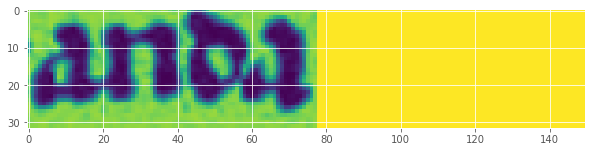

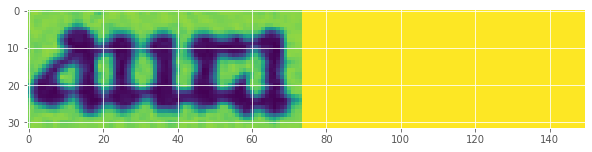

In [55]:
#a function to do the preprocessing, standardizing the size and applying data augmentation if required
def preprocess(img, imgSize,augmentation=False):
    wt, ht = imgSize
    h, w = img.shape
    f = min(wt / w, ht / h)
    tx = (wt - w * f) / 2
    ty = (ht - h * f) / 2
    # map image into target image
    M = np.float32([[f, 0, 0], [0, f, ty]])
    M_translation_center = np.float32([[1, 0, wt/2-w/2], [0, 1, 0]])
    M_translation_right = np.float32([[1, 0, wt-w], [0, 1, 0]])
    target = np.ones(imgSize[::-1]) * 255    
    img_resized = cv2.warpAffine(img, M, imgSize,borderMode=cv2.BORDER_CONSTANT,borderValue=255)
    img_translated_center = cv2.warpAffine(img, M_translation_center, imgSize,borderMode=cv2.BORDER_CONSTANT,borderValue=255)
    img_translated_right = cv2.warpAffine(img, M_translation_right, imgSize,borderMode=cv2.BORDER_CONSTANT,borderValue=255)

    output = []
    output.append(img_resized)
    
    
    if augmentation:
        output.append(img_translated_center)
        output.append(img_translated_right)
        rows,cols = img.shape
        rotations = [2,-2]
        
        for angle in rotations:
            stretch = random.random() # -0.5 .. +0.5
            wStretched = max(int(img.shape[1] * (1 + stretch/2)), 1) # random width, but at least 1
            wStretched = int(img.shape[1] * (1 + stretch/5))
            im_stretched = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5        
            rows_s,cols_s = im_stretched.shape
            M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
            im_streched_rotated = cv2.warpAffine(im_stretched,M_rot,(cols_s,rows_s),borderMode=cv2.BORDER_CONSTANT,borderValue=255)
            im_streched_rotated = cv2.warpAffine(im_streched_rotated, M, imgSize,borderMode=cv2.BORDER_CONSTANT,borderValue=255)
            output.append(im_streched_rotated)

    return output


image_path = os.path.abspath(r'data/images')
label_path = os.path.abspath(r'data/')


label_df = pd.read_excel(os.path.join(label_path,'labels.xlsx')) #dataframe with image data
label_df['freq'] = label_df.groupby('text')['text'].transform('count') #add a column with the count to extract unique words for validation

charList = []

maxTextLen = 32 #parameter of the neural network

image_list = os.listdir(image_path)

load_images = []
label_list = []
single_word_list = []
validation_images_list = []
validation_label_list = []

target_size = (150,32) #the images are standardized to a width of 150 pixels and a height of 32 pixels

#in this loop unique words are extracted
for i in label_df[label_df['freq']==1]['text']: 
    if 'ç' not in list(i) and 'x' not in list(i) and len(i)<5 and len(single_word_list)<6 and len(i)>3:
        single_word_list.append(str(i))


for idx,im in enumerate(image_list):
    #number extracted from file name, avoids file extension
    im_number = im[:-4]
    #gets the label associated with the image
    word = label_df[label_df['number']==int(im_number)]['text'].to_string(index=False) 
    #populates the charList, containing the individual letters contained on all the words
    for letter in list(word[1:]):
        if letter not in charList:
            charList.append(letter)
    
    #populates the validation image and label, no augmentation is applied to this list to keep them unique
    if word[1:] in single_word_list:
        im_read = cv2.imread(os.path.join(image_path,im), cv2.IMREAD_GRAYSCALE)
        
        #(thresh, blackAndWhiteImage) = cv2.threshold(im_read, 80, 255, cv2.THRESH_BINARY)
        
        im_read_processed = preprocess(im_read,target_size,augmentation=False)
        for im_process in im_read_processed:
            validation_images_list.append(im_process)
        for k in range(len(im_read_processed)):
            validation_label_list.append(word[1:])
    
    #the non unique words populate the image and label set, data augmentation can be controled
    else:
        im_read = cv2.imread(os.path.join(image_path,im), cv2.IMREAD_GRAYSCALE)
        im_read_processed = preprocess(im_read,target_size,augmentation=True)
        
        #for printing an example of augmentation setup idx==int, -1 to avoid
        if idx == -1:
            last_processed = np.concatenate([p[np.newaxis,...] for p in im_read_processed], axis=0)
            for j in last_processed:
                plt.figure(figsize=(10,10))
                plt.imshow(j)
                
        for im_process in im_read_processed:
            load_images.append(im_process)
        for k in range(len(im_read_processed)):
            label_list.append(word[1:])


    
charList = sorted(charList)

print('Charlist:')
print(charList)
    
    
#the images that will be use during the training and validation are transformed into arrays
im_array = np.concatenate([p[np.newaxis,...] for p in load_images], axis=0)
im_array_validation = np.concatenate([p[np.newaxis,...] for p in validation_images_list], axis=0)

# percentage of training
train = 90 

#random selection of data for training and testing
idx_train = int(len(load_images)*train/100)

random_list = np.random.permutation(len(load_images))
train_idx = random_list[0:idx_train-1]
test_idx = random_list[idx_train-1:]

imgs_train = im_array[train_idx,:,:]
imgs_test = im_array[test_idx,:,:]

text_train = [label_list[i] for i in train_idx]
text_test = [label_list[i] for i in test_idx]

#quick input data check
print('')
print('img --> train: {}, test: {}, validation: {}'.format(imgs_train.shape,imgs_test.shape,im_array_validation.shape))
print('text --> train: {}, test: {},validation: {}'.format(len(text_train),len(text_test),len(validation_label_list)))

#print(text_test)
print('')
print('Validation labels:')
print(validation_label_list)
for j in im_array_validation:
    plt.figure(figsize=(10,10))
    plt.imshow(j)

# Neural network build-up

## Convolutional layer

In [4]:
#Input placeholder based on target_image size
input_image = tf.placeholder(tf.float32, shape=(None, target_size[1], target_size[0]))


#expand the image one axis to account for channel modification
cnn_input = tf.expand_dims(input=input_image, axis=3) 

# create layers
out1 = cnn_input 
kernel_definition1 = [5, 5, 1, 32] # i
kernel1 = tf.Variable(tf.truncated_normal(kernel_definition1, stddev=0.1))
conv1 = tf.nn.conv2d(out1, kernel1, padding='SAME',  strides=(1,1,1,1))
conv_norm1 = tf.layers.batch_normalization(conv1, training=True)
relu1 = tf.nn.relu(conv_norm1)
out2 = tf.nn.max_pool(relu1, (1, 2, 2, 1), (1, 2, 2, 1), 'VALID')

kernel_definition2 = [5, 5, 32, 64] # i
kernel2 = tf.Variable(tf.truncated_normal(kernel_definition2, stddev=0.1))
conv2 = tf.nn.conv2d(out2, kernel2, padding='SAME',  strides=(1,1,1,1))
conv_norm2 = tf.layers.batch_normalization(conv2, training=True)
relu2 = tf.nn.relu(conv_norm2)
out3 = tf.nn.max_pool(relu2, (1, 2, 2, 1), (1, 2, 2, 1), 'VALID')

kernel_definition3 = [3, 3, 64, 128] # i
kernel3 = tf.Variable(tf.truncated_normal(kernel_definition3, stddev=0.1))
conv3 = tf.nn.conv2d(out3, kernel3, padding='SAME',  strides=(1,1,1,1))
conv_norm3 = tf.layers.batch_normalization(conv3, training=True)
relu3 = tf.nn.relu(conv_norm3)
out4 = tf.nn.max_pool(relu3, (1, 2, 1, 1), (1, 2, 1, 1), 'VALID')

kernel_definition4 = [3, 3, 128, 128] # i
kernel4 = tf.Variable(tf.truncated_normal(kernel_definition4, stddev=0.1))
conv4 = tf.nn.conv2d(out4, kernel4, padding='SAME',  strides=(1,1,1,1))
conv_norm4 = tf.layers.batch_normalization(conv4, training=True)
relu4 = tf.nn.relu(conv_norm4)
out5 = tf.nn.max_pool(relu4, (1, 2, 1, 1), (1, 2, 1, 1), 'VALID')

kernel_definition5 = [3, 3, 128, 256] # i
kernel5 = tf.Variable(tf.truncated_normal(kernel_definition5, stddev=0.1))
conv5 = tf.nn.conv2d(out5, kernel5, padding='SAME',  strides=(1,1,1,1))
conv_norm5 = tf.layers.batch_normalization(conv5, training=True)
relu5 = tf.nn.relu(conv_norm5)
out6 = tf.nn.max_pool(relu5, (1, 2, 1, 1), (1, 2, 1, 1), 'VALID')


CNN_out = out6

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.


## Recurrent neural network

By using a recurrent neural network the optimizer is able to use information from previous time-steps. Using the Long Shorterm Memory (LSTM) resolves de pr>oblem of vanishing gradients.
To improve the results a bidirectional RNN is used.

https://www.tensorflow.org/api_docs/python/tf/compat/v1/nn/rnn_cell/MultiRNNCell

https://www.tensorflow.org/api_docs/python/tf/compat/v1/nn/bidirectional_dynamic_rnn

In [112]:
#Input to RNN is 37 time-steps (150 pixels divided by 2, two times in the CNN) with 256 features
#Reduce CNN output dimension, (?,1,37,256) --> (?,37,256)
RNN_in = tf.squeeze(CNN_out, axis=[1])

#LSTM creation. Two layers. LSTM to resolve the vanishing gradients issue.
numHidden = 256
cells = [tf.nn.rnn_cell.LSTMCell(num_units=numHidden, state_is_tuple=True) for i in range(2)] # 2 layers

# stack basic cells
stacked = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)

# bidirectional RNN, fw and bw represent the forward and the backward cells
# B (Batch) T (Timesteps) F (Features) H (Hidden layers)
# BxTxF -> BxTx2H
((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, cell_bw=stacked, inputs=RNN_in, dtype=RNN_in.dtype)

# BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)

# kernel applied has a size of 1x1 input of 512 and output size of len(charlist)
kernel = tf.Variable(tf.truncated_normal([1, 1, numHidden * 2, len(charList) + 1], stddev=0.1))
rnnOut3d = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=[2])

ValueError: Variable bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\alberto\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1949, in __init__
    self._traceback = tf_stack.extract_stack()
  File "C:\Users\alberto\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3477, in _create_op_internal
    ret = Operation(
  File "C:\Users\alberto\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 742, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "C:\Users\alberto\anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 1752, in variable_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "C:\Users\alberto\anaconda3\lib\site-packages\tensorflow\python\ops\state_ops.py", line 74, in variable_op_v2
    return gen_state_ops.variable_v2(


## CTC

https://www.tensorflow.org/api_docs/python/tf/compat/v1/nn/ctc_loss

https://www.tensorflow.org/api_docs/python/tf/nn/ctc_greedy_decoder

In [6]:
# B (Batch) T (Timesteps) C (Characters)
# BxTxC -> TxBxC. It is require to transpose the output from the RNN to match the ctc_loss requirements
ctcIn3dTBC = tf.transpose(rnnOut3d, [1, 0, 2])

# ground truth text as sparse tensor, many zeros present in the matrix
gtTexts = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]) , tf.placeholder(tf.int32, [None]), tf.placeholder(tf.int64, [2]))

# calc loss for batch
seqLen = tf.placeholder(tf.int32, [None])
loss = tf.reduce_mean(tf.nn.ctc_loss(labels=gtTexts, inputs=ctcIn3dTBC, sequence_length=seqLen, ctc_merge_repeated=True))

#decoder
decoder = tf.nn.ctc_greedy_decoder(inputs=ctcIn3dTBC, sequence_length=seqLen)
#optimizer
optimizer = tf.compat.v1.train.AdamOptimizer().minimize(loss)
#Saver
saver = tf.train.Saver(max_to_keep=1)

In [125]:
def toSparse(texts):
    "put ground truth texts into sparse tensor for ctc_loss"
    indices = []
    values = []
    shape = [len(texts), 0]  # last entry must be max(labelList[i])

    # go over all texts
    for (batchElement, text) in enumerate(texts):
        # convert to string of label (i.e. class-ids)
        labelStr = [charList.index(c) for c in text]
        # sparse tensor must have size of max. label-string
        if len(labelStr) > shape[1]:
            shape[1] = len(labelStr)
        # put each label into sparse tensor
        for (i, label) in enumerate(labelStr):
            indices.append([batchElement, i])
            values.append(label)

    return (indices, values, shape)

def decoderOutputToText(ctcOutput, batchSize):
    "extract texts from output of CTC decoder"
    decoded = ctcOutput[0][0]

    # contains string of labels for each batch element
    labelStrs = [[] for _ in range(batchSize)]

    # go over all indices and save mapping: batch -> values
    for (idx, idx2d) in enumerate(decoded.indices):
        label = decoded.values[idx]
        batchElement = idx2d[0]  # index according to [b,t]
        labelStrs[batchElement].append(label)

    # map labels to chars for all batch elements
    return [str().join([charList[c] for c in labelStr]) for labelStr in labelStrs]


def error_rate(words,recognized):
    numWordOK = 0
    numWordTotal = 0
    for i in range(len(recognized)):
        numWordOK += 1 if words[i] == recognized[i] else 0
        numWordTotal += 1
    wordAccuracy = numWordOK / numWordTotal
    print('Word accuracy: %f%%.' % (wordAccuracy*100.0))


retrieve_model_data = True
save_model = False
continue_training = False


with tf.Session() as sess:
    
    if retrieve_model_data:
        sess=tf.Session() # TF session
        modelDir = os.path.abspath(r'saved')
        latestSnapshot = tf.train.latest_checkpoint(modelDir)
        if latestSnapshot:
            print('Retrieved model from ' + latestSnapshot)
            saver.restore(sess, latestSnapshot)
            print('')
            evalList = [decoder]

            numBatchElements = len(imgs_test)
            feedDict = {input_image: imgs_test,seqLen: [maxTextLen] * numBatchElements}
            evalRes = sess.run(evalList, feedDict)
            decoded = evalRes[0]
            texts = decoderOutputToText(decoded, numBatchElements)
            print('Recognized test: {}'.format(texts))
            error_rate(text_test,texts)
            
            print('')
            
            numBatchElements = len(im_array_validation)
            feedDict = {input_image: im_array_validation,seqLen: [maxTextLen] * numBatchElements}
            evalRes = sess.run(evalList, feedDict)
            decoded = evalRes[0]
            texts = decoderOutputToText(decoded, numBatchElements)
            print('Validation text: {}'.format(validation_label_list))
            print('Recognized validation: {}'.format(texts))
            error_rate(validation_label_list,texts)
            
            #calculate middle steps to track evolution of data
            res0 = sess.run(out1,feed_dict={input_image: im_array_validation})
            res1 = sess.run(out2,feed_dict={input_image: im_array_validation})
            res2 = sess.run(out3,feed_dict={input_image: im_array_validation})
            res3 = sess.run(out4,feed_dict={input_image: im_array_validation})
            res4 = sess.run(out5,feed_dict={input_image: im_array_validation})
            res5 = sess.run(out6,feed_dict={input_image: im_array_validation})
            res6 = sess.run(RNN_in,feed_dict={input_image: im_array_validation})
            res8 = sess.run(rnnOut3d,feed_dict={input_image: im_array_validation})
            res9 = sess.run(concat,feed_dict={input_image: im_array_validation})
            
        
    
    else:
        batch_arr = []
        loss_arr = []
        iteration = 0
        fig,ax=plt.subplots()
        sess.run(tf.global_variables_initializer())

        mini_batch_size = 60
        n_epochs = 25
        n_train = imgs_train.shape[0]
        
        if continue_training:
            modelDir = os.path.abspath(r'saved')
            latestSnapshot = tf.train.latest_checkpoint(modelDir)
            print('Retrieved model from ' + latestSnapshot)
            saver.restore(sess, latestSnapshot)


        for epoch_i in range(n_epochs):
            #check if checkpoint folder exists
            checkpoint_dir = os.path.isdir(r'saved')
            if checkpoint_dir:
                pass
            else:
                os.mkdir(r'saved')
            
            # iterate minibatches
            idx = np.random.permutation(n_train)
            for mb_idx in range(n_train // mini_batch_size):
                sub_idx = idx[mini_batch_size * mb_idx : mini_batch_size * (mb_idx+1)]
                img_batch, text_batch = imgs_train[sub_idx], [text_train[i] for i in sub_idx]
                sparse = toSparse(text_batch)
                numBatchElements = len(img_batch)
                evalList = [optimizer, loss]
                feedDict = {input_image: img_batch, gtTexts: sparse,seqLen: [maxTextLen] * numBatchElements}
                _, lossVal = sess.run(evalList, feedDict)

                
                batch_arr.append(iteration)
                loss_arr.append(lossVal)
                iteration = iteration + 1





                numBatchElements = len(imgs_test)
                evalList = [decoder]
                feedDict = {input_image: imgs_test,seqLen: [maxTextLen] * numBatchElements}
                evalRes = sess.run(evalList, feedDict)
                decoded = evalRes[0]
                texts = decoderOutputToText(decoded, numBatchElements)


                if mb_idx%10 == 0:
                    print(f'Epoch: {epoch_i} Batch: {mb_idx} Loss: {lossVal}')
                    print('Recognized: {}'.format(texts))
                    error_rate(text_test,texts)
                    if save_model:
                        saver.save(sess, r'saved/save',global_step=1)

        print(f'Epoch: {epoch_i} Batch: {mb_idx} Loss: {lossVal}')
        print('Recognized: {}'.format(texts))

        numBatchElements = len(im_array_validation)
        evalList = [decoder]
        feedDict = {input_image: im_array_validation,seqLen: [maxTextLen] * numBatchElements}
        evalRes = sess.run(evalList, feedDict)
        decoded = evalRes[0]
        texts = decoderOutputToText(decoded, numBatchElements)
        print('Validation text: {}'.format(validation_label_list))
        print('Recognized validation: {}'.format(texts))
        ax.plot(batch_arr,loss_arr)

Retrieved model from E:\CAS\middleage (copy)\saved\save-1
INFO:tensorflow:Restoring parameters from E:\CAS\middleage (copy)\saved\save-1

Recognized test: ['del', 'sin', 'passa', 'piscis', 'las', 'forado', 'el', 'quan', 'omne', 'toda', 'de', 'non', 'que', 'se', 'de', 'qui', 'amador', 'nasciere', 'uenzra', 'entraren', 'faz', 'atreuudo', 'sera', 'la', 'uenus', 'mercado', 'uientre', 'sube', 'poder', 'alguna', 'uilla', 'con', 'salier', 'enel', 'sube', 'su', 'mucho', 'con', 'ala', 'en', 'qui', 'enla', 'bien', 'en', 'fierro', 'fizieres', 'delas', 'cuerpo', 'en', 'fierro', 'obra', 'sobre', 'dannaren', 'nos', 'nada', 'conuiene', 'de', 'soffridor', 'culuebra', 'natura', 'enel', 'scorpion', 'a', 'sera', 'fierro', 'omne', 'de', 'pagara', 'nada', 'si', 'enel', 'nos', 'la', 'semeian', 'quisieres', 'ga', 'lazrado', 'poner', 'sube', 'en', 'culuebras', 'nasciere', 'amador', 'fizieres', 'uenus', 'segundo', 'pies', 'non', 'manso', 'de', 'planetas', 'enla', 'sera', 'que', 'quedara', 'fazer', 'toda', 'sus

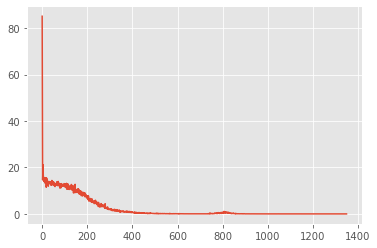

In [58]:
plt.plot(batch_arr,loss_arr)

## What is the CNN doing?

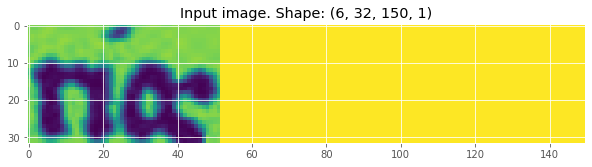

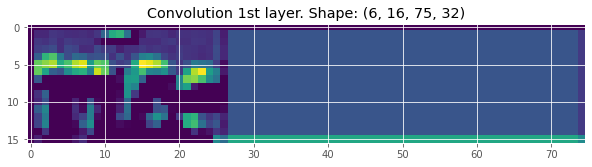

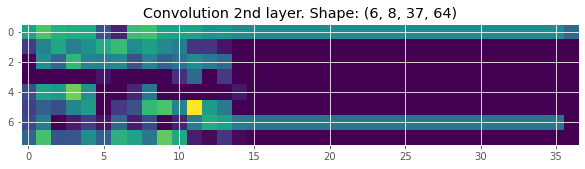

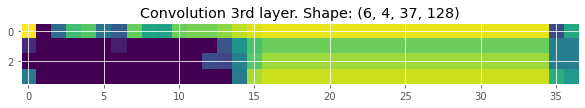

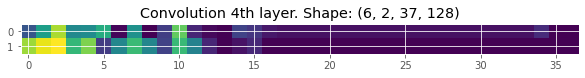

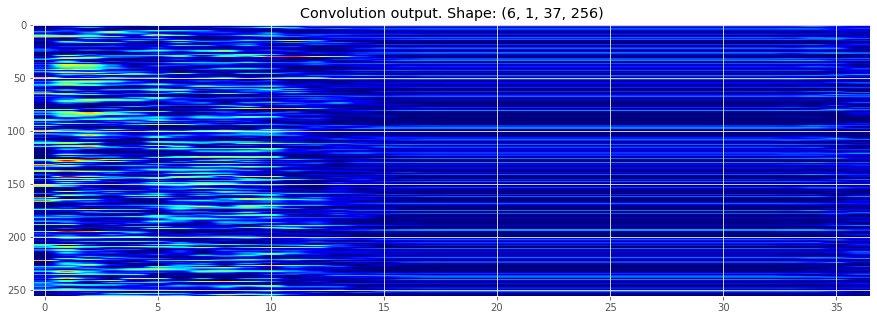

In [131]:
img_num = 3

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Input image. Shape: {}'.format(res0.shape))
ax.imshow(res0[img_num,:,:,0])

fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.set_title('Convolution 1st layer. Shape: {}'.format(res1.shape))
plt.imshow(res1[img_num,:,:,0])

fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_title('Convolution 2nd layer. Shape: {}'.format(res2.shape))
plt.imshow(res2[img_num,:,:,0])

fig4, ax4 = plt.subplots(figsize=(10,10))
ax4.set_title('Convolution 3rd layer. Shape: {}'.format(res3.shape))
plt.imshow(res3[img_num,:,:,0])

fig5, ax5 = plt.subplots(figsize=(10,10))
ax5.set_title('Convolution 4th layer. Shape: {}'.format(res4.shape))
plt.imshow(res4[img_num,:,:,0])

fig6, ax6 = plt.subplots(figsize=(15,5))
ax6.set_title('Convolution output. Shape: {}'.format(res5.shape))
ax6.imshow(res5[img_num,0,:,:].T, aspect='auto',cmap=plt.cm.jet)





## How does the concatenation of fw,bw looks like and how is the output from RNN?

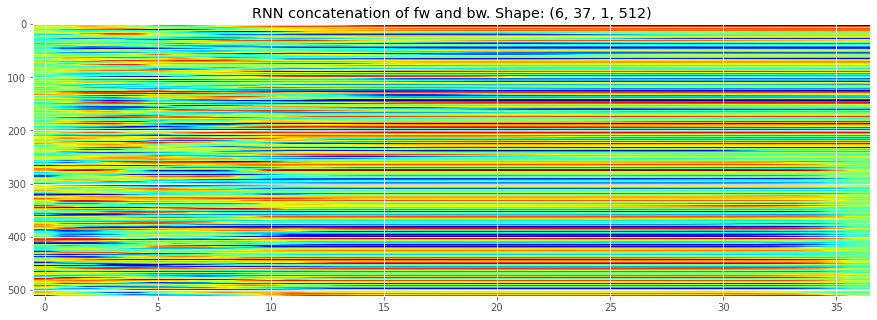

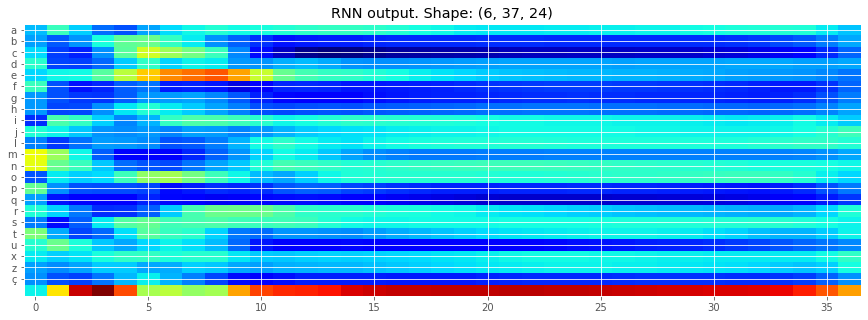

In [132]:
fig7_2, ax7_2 = plt.subplots(figsize=(15,5))
ax7_2.set_title('RNN concatenation of fw and bw. Shape: {}'.format(res9.shape))
ax7_2.imshow(res9[img_num,:,0,:].T, aspect='auto',cmap=plt.cm.jet)




fig7, ax7 = plt.subplots(figsize=(15,5))
ax7.set_title('RNN output. Shape: {}'.format(res8.shape))
ax7.set_yticks(range(len(charList)))
ax7.set_yticklabels(charList+['space'])
ax7.imshow(res8[img_num,:,:].T, aspect='auto',cmap=plt.cm.jet)

## How does the sparse tensor input to the CTC looks like?

[[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3]]
[0, 19, 4, 16, 3, 13, 16, 13, 0, 3, 8, 1, 16, 8, 13, 17, 0, 12, 3, 0, 0, 19, 16, 0]
2.3.1


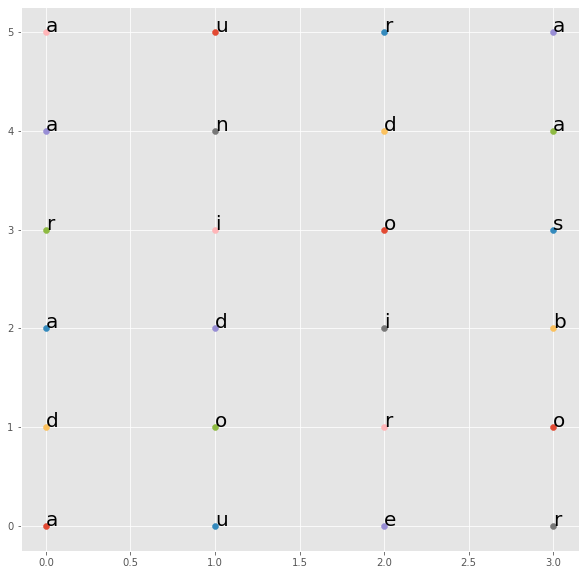

In [111]:
indices, values, shape = toSparse(validation_label_list)
print(indices)
print(values)
print(tf.__version__)

fig, ax = plt.subplots(figsize=(10,10))
for i,j in zip(indices,values):
    ax.scatter(i[1],i[0])
    ax.text(i[1],i[0],charList[j],fontsize=20)

## How does the decoded matrix looks like?

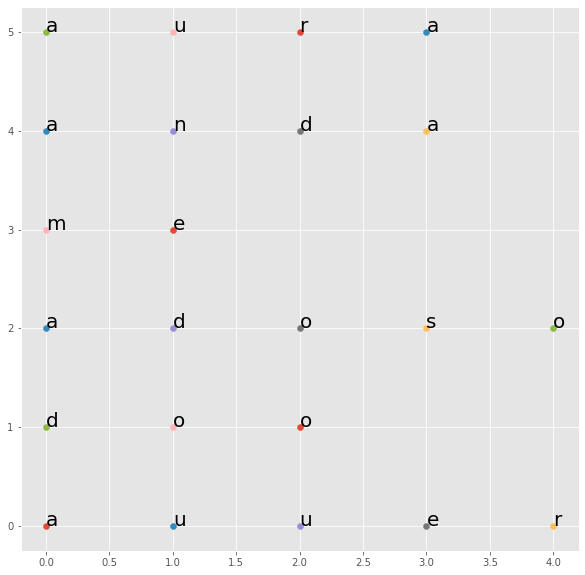

In [121]:
fig, ax = plt.subplots(figsize=(10,10))
for i,j in zip(decoded[0][0].indices,decoded[0][0].values):
    ax.scatter(i[1],i[0])
    ax.text(i[1],i[0],charList[j],fontsize=20)